# Neural Network


In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras import optimizers
from keras.datasets import boston_housing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

mean = x_train.mean(axis = 0)
std = x_train.std(axis = 0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std #정규화 과정
epoch = 20
model = Sequential()
model.add(Dense(13, activation='relu', input_shape=(13,), name="Hidden_Layer1"))
model.add(Dense(13, activation='relu', name="Hidden_Layer2")) #regression임을8 감안한 relu function 사용
model.add(Dense(1, name = "Output_Layer")) # output_layer
model.compile(optimizer=optimizers.Adam(learning_rate=0.01),loss='mse') #model의 생성 method등을 parameter로 가진다. 
model.summary() #layer에 따른 prameter의 숫자, output의 모형을 출력해줌

out = model.fit(x_train, y_train, epochs=epoch,validation_data=(x_test, y_test),batch_size=30) #모델 구현 및 validation

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer1 (Dense)        (None, 13)                182       
_________________________________________________________________
Hidden_Layer2 (Dense)        (None, 13)                182       
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 14        
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
14/14 [==============================] - 14s 42ms/step - loss: 496.7288 - val_loss: 369.7779
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 255.6875 - val_loss: 105.7917
Epoch 3/20
14/14 [==============================] - 0s 5ms/step - loss: 85.9364 - val_loss: 44.0955
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 31.7136 - 

# Linear Regression

ordinary
train r2: 0.574044 	test r2: 0.636126 



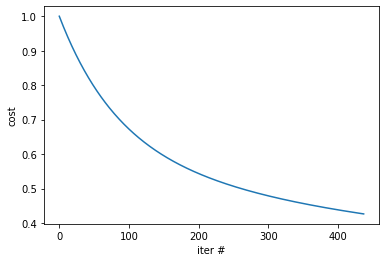

ridge
train r2: 0.668132 	r2 test: 0.734755 



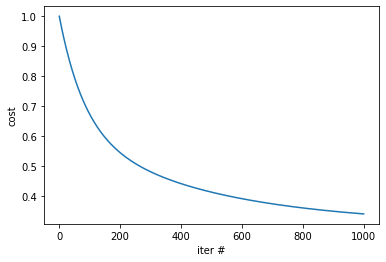

lasso
train r2: 0.653855 	r2 test: 0.729588 



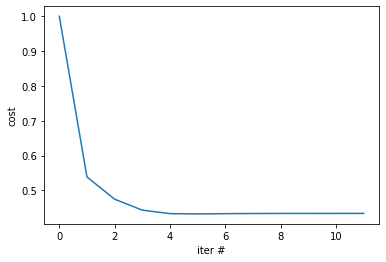

In [ ]:
from keras.datasets import boston_housing
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import pandas as pd

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

#functions for data pre-processing
def norm_x(x):
    x2 = x.copy()
    x2 -= x2.mean(axis=0)
    x2 /= x2.std(axis=0)
    x0 = np.ones((x.shape[0], 1))
    x2 = np.concatenate((x0, x2), axis = 1)
    return x2

def norm_y(x):
    x2 = x.copy()
    x2 -= x2.mean()
    x2 /= x2.std()   
    return x2

def r2_score(true, pred):
    r2 = skm.r2_score(true, pred)
    return round(r2, 6)

#lasso
def z_compute(X):
    z = np.sum(X*X, axis = 0) #Compute sum for each column
    return z
                                                                  
#class definition 
class LinearRegression:
    def __init__(self, x, y):
        self.y_mean = y.mean()
        self.y_std = y.std()

        self.x = norm_x(x)
        self.y = norm_y(y).reshape(y.shape[0], -1)

        self.n = self.x.shape[1]
        self.m = self.x.shape[0]

        self.z = z = np.sum(self.x*self.x, axis = 0)


    def denorm(self, h):
        return h * self.y_std + self.y_mean

    def GradDescent(self, h):
        return np.mean((h-self.y)*self.x, axis = 0).reshape(-1, 1)

    def plot_cost(self, cost_val):
        cost_val = np.array(cost_val)
        plt.plot(cost_val)
        plt.xlabel("iter #")
        plt.ylabel("cost")
        plt.show()

    def ordinary(self, learning_rate):
        tolerance = 1e-3
        iter = 0
        iter_max = 1000

        cost_val = [] #cost value list for plotting
        w = np.zeros((self.n, 1))
        h = np.dot(self.x, w)

        while(True):
            cost = np.mean(np.square(h-self.y)) #mse
            cost_val.append(cost)
            #update
            w_update = w - learning_rate * LinearRegression.GradDescent(self, h)
            h = np.dot(self.x, w_update)

            if np.sum(abs(w_update - w)) < tolerance:
                break
            elif iter == iter_max:
                break
            else:
                w = w_update
                iter+=1

        h = LinearRegression.denorm(self, h)
        return h, w, cost_val

    def ridge(self, learning_rate, lmbda):
        tolerance = 1e-4
        iter = 0
        iter_max = 1000

        cost_val = []
        w = np.zeros((self.n, 1))
        b = w[0].reshape(1, -1)
        w_ = w[1:]  
        h = np.dot(self.x, w)

        while(True):
            cost = np.mean(np.square(h-self.y)) + (lmbda/2) * np.sum(np.square(w))
            cost_val.append(cost)
            d_cost = LinearRegression.GradDescent(self, h)

            #update
            b = b - d_cost[0]
            w_update = w_ - learning_rate * (d_cost[1:] + (lmbda/self.m)*np.sum(w))
            w = np.concatenate((b, w_update), axis=0)
            h = np.dot(self.x, w)

            if np.sum(abs(w_update - w_)) < tolerance:
                break
            elif iter == iter_max:
                break
            else:
                w_ = w_update
                iter+=1

        h = LinearRegression.denorm(self, h)
        return h, w, cost_val

#lasso
    def rho_compute(self, y, X, w, j):
        X_k = np.delete(X,j,1)
        w_k = np.delete(w,j)
        predict_k = np.matmul(X_k, w_k)
        rho_j = np.sum(X[:,j]*(y - predict_k))
        return rho_j

    def coordinate_descent(self, y, X, w, alpha, z):
        cost_val = []
        h = np.dot(X, w)

        tolerance = 1e-4
        max_step = 100.
        iteration = 0
        while(max_step > tolerance):
            cost = np.mean(np.square(h-y)) + alpha * np.sum(np.abs(w))
            cost_val.append(cost)
            iteration += 1
            old_weights = np.copy(w)
            for j in range(len(w)):
                rho_j = LinearRegression.rho_compute(self, y, X, w, j)
                if j == 0: 
                    w[j] = rho_j/z[j]
                elif rho_j < -alpha*len(y):
                    w[j] = (rho_j + (alpha*len(y)))/z[j]
                elif rho_j > -alpha*len(y) and rho_j < alpha*len(y):
                    w[j] = 0.
                elif rho_j > alpha*len(y):
                    w[j] = (rho_j - (alpha*len(y)))/z[j]
                else:
                    w[j] = np.NaN

            step_sizes = abs(old_weights - w)
            max_step = step_sizes.max()
            h = np.dot(X, w)

        h = LinearRegression.denorm(self, h)
        return h, w, cost_val
        
    def prediction(self, x_test, parameter):
        x_test = norm_x(x_test)
        y_pred = np.dot(x_test, parameter)
        y_pred = LinearRegression.denorm(self, y_pred)
        return y_pred

#instance 선언
model = LinearRegression(x_train, y_train)

#ordinary
print("ordinary")
h_ols, w_ols, cost_val_ols = model.ordinary(1e-3)
y_pred_ols = model.prediction(x_test, w_ols)
print("train r2:", r2_score(y_train, h_ols), "\ttest r2:", r2_score(y_test, y_pred_ols), "\n")
model.plot_cost(cost_val_ols)

#ridge
print("ridge")
h_ridge, w_ridge, cost_val_ridge = model.ridge(1e-3, 1e-1)
y_pred_ridge = model.prediction(x_test, w_ridge)
print("train r2:", r2_score(y_train, h_ridge), "\tr2 test:", r2_score(y_test, y_pred_ridge), "\n")
model.plot_cost(cost_val_ridge)

#lasso
print("lasso")
X = norm_x(x_train)
y = norm_y(y_train)
w = np.zeros(X.shape[1], dtype = float)
z = z_compute(X)

h_lasso, w_lasso, cost_val_lasso = model.coordinate_descent(y,X,w,1e-1,z)
y_pred_lasso = model.prediction(x_test, w_lasso)
print("train r2:", r2_score(y_train, h_lasso), "\tr2 test:", r2_score(y_test, y_pred_lasso), "\n")
model.plot_cost(cost_val_lasso)

In [ ]:
#ordinary 예측값 실제값 비교 표
y_pred_ols = y_pred_ols.reshape(102, -1)
y_true = y_test.reshape(102, -1)
col = ["pred", "true"]
compare_list = np.concatenate((y_pred_ols, y_true), axis = 1)
display(pd.DataFrame(compare_list, columns = col))

,pred,true
0,10.820872,7.2
1,20.746133,18.8
2,22.884031,19.0
3,25.856753,27.0
4,24.613287,22.2
...,...,...
97,27.474430,21.9
98,24.680844,24.1
99,30.642297,50.0
100,27.462453,26.7


In [ ]:
#ridge 예측값 실제값 비교 표
y_pred_ridge = y_pred_ridge.reshape(102, -1)
compare_list = np.concatenate((y_pred_ridge, y_true), axis = 1)
display(pd.DataFrame(compare_list, columns = col))

,pred,true
0,9.083957,7.2
1,20.221637,18.8
2,21.648750,19.0
3,28.792747,27.0
4,24.304588,22.2
...,...,...
97,33.394408,21.9
98,24.534054,24.1
99,36.064195,50.0
100,30.040605,26.7


In [ ]:
#lasso 예측값 실제값 비교 표
y_pred_lasso = y_pred_lasso.reshape(102, -1)
compare_list = np.concatenate((y_pred_lasso, y_true), axis = 1)
display(pd.DataFrame(compare_list, columns = col))

,pred,true
0,11.194565,7.2
1,18.880853,18.8
2,21.234874,19.0
3,28.886933,27.0
4,23.521104,22.2
...,...,...
97,35.534130,21.9
98,24.900213,24.1
99,37.071675,50.0
100,27.821579,26.7


In [ ]:
#파라미터 계수 비교
pd.set_option('display.max_rows', 14)
name_list = ["ordinary", "ridge", "lasso"]
coef_list = np.concatenate((w_ols, w_ridge), axis = 1)
coef_list = np.concatenate((coef_list, w_lasso.reshape(-1, 1)), axis = 1)
display(pd.DataFrame(coef_list, columns = name_list))

,ordinary,ridge,lasso
0,3.353611e-16,1.697762e-15,1.763166e-15
1,-5.988130e-02,-6.814927e-02,0.000000e+00
2,5.765558e-02,6.328428e-02,0.000000e+00
3,-6.371149e-02,-5.792999e-02,0.000000e+00
4,5.619861e-02,9.234777e-02,3.524931e-02
5,-5.569054e-02,-5.483399e-02,0.000000e+00
6,1.752975e-01,2.694126e-01,2.838230e-01
7,-3.604386e-02,-1.823410e-02,0.000000e+00
8,-1.026611e-02,-7.633385e-02,0.000000e+00
9,-3.208045e-02,1.946678e-03,0.000000e+00


# k 교차검증

In [ ]:
# 교차검증
# 전체 데이터 불러오기
(whole_x, whole_y), (void1,void2) = boston_housing.load_data(test_split=0)

# 트레인 데이터와 테스트 데이터 쌍 분리, 5개 

test_split = 0.2 # 이번 경우에 테스트 데이터의 비율을 0.2로 함 
k = (int)(1/test_split) # 테스트 데이터의 비율에 따라 k가 결정됨, 이번 경우 5
kfolds_size = np.floor(test_split * np.shape(whole_x)[0]).astype(int) # 101 (=506/5)


# test data의 인덱스를 계산하는 함수
def index_start(i):
  if (i == k):
    idx = np.shape(whole_x)[0] - (kfolds_size-1)
  else:
    idx = i * kfolds_size
  return idx

def index_end(i):
  if (i == k):
    idx = np.shape(whole_x)[0]
  else:
    idx = (i+1)*kfolds_size - 1
  return idx

# kfold 실행
def kfold(function, k):
    cv_accuracy = []
    if (function=='lr'):
        print("------linear regression-----")
    elif (function=='ridge'):
        print("----- ridge regression -----")
    elif (function=='lasso'):
        print("----- lasso regression -----")
    else:
        print("No such function")

    print("train size ", whole_x.shape[0]-kfolds_size, "\ttest size: ", kfolds_size, "\n")

    for i in range(k):
        # 데이터 분할
        indices = range(index_start(i), index_end(i)+1)

        fold_x_test = whole_x[index_start(i):index_end(i)+1].copy()
        fold_x_train = np.delete(whole_x, indices, axis=0)
        fold_y_test = whole_y[index_start(i):index_end(i)+1].copy()
        fold_y_train = np.delete(whole_y, indices, axis=0) 

        model_k = LinearRegression(fold_x_train, fold_y_train)

        # 함수별로 갈라지는 부분

        if (function=='lr'):
            h, w, cost_val = model_k.ordinary(1e-2)

        elif (function == 'ridge'):
            h, w, cost_val = model_k.ridge(1e-2, 1e-1)

        elif (function == 'lasso'):
            X = norm_x(fold_x_train)
            y = norm_y(fold_y_train)
            w = np.zeros(X.shape[1], dtype = float)
            z = z_compute(X)
            h, w, cost_val = model_k.coordinate_descent(y,X,w,1e-1,z)

        y_pred_k = model_k.prediction(fold_x_test, w)

        accuracy2 = r2_score(fold_y_train, h)
        accuracy = r2_score(fold_y_test, y_pred_k)
        print(i, "\ttrain r2 score:", accuracy2, "\ttest r2 score:", accuracy)

        cv_accuracy.append(accuracy)

    print('평균: ', round(np.mean(cv_accuracy), 6), "\n")

print("k fold cross validation")
kfold("lr", k)
kfold("ridge", k)
kfold("lasso", k) 
    

k fold cross validation
------linear regression-----
train size  405 	test size:  101 

0 	train r2 score: 0.726221 	test r2 score: 0.713824
1 	train r2 score: 0.724094 	test r2 score: 0.753462
2 	train r2 score: 0.750017 	test r2 score: 0.5562
3 	train r2 score: 0.736493 	test r2 score: 0.621215
4 	train r2 score: 0.729292 	test r2 score: 0.761951
평균:  0.68133 

----- ridge regression -----
train size  405 	test size:  101 

0 	train r2 score: 0.73358 	test r2 score: 0.724822
1 	train r2 score: 0.730995 	test r2 score: 0.748478
2 	train r2 score: 0.757039 	test r2 score: 0.572693
3 	train r2 score: 0.742977 	test r2 score: 0.633645
4 	train r2 score: 0.736397 	test r2 score: 0.756265
평균:  0.687181 

----- lasso regression -----
train size  405 	test size:  101 

0 	train r2 score: 0.667397 	test r2 score: 0.632937
1 	train r2 score: 0.657501 	test r2 score: 0.723131
2 	train r2 score: 0.692717 	test r2 score: 0.543045
3 	train r2 score: 0.684442 	test r2 score: 0.556817
4 	train r2 sc